Copyright(c) 2021 UNIADEX, Ltd. All Rights Reserved.  
CONFIDENTIAL

# 分析
切り出したショットデータを取得し、分析します。  
以下は特定ショットのデータを取得/確認し、特徴点（荷重開始点/最大荷重点/破断点）を抽出、その後全ショットから特徴点を抽出するサンプルコードです。抽出した特徴点はElasticsearchに格納されます。

In [3]:
# ライブラリインポート
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../src/'))
from data_reader.data_reader import DataReader
from elastic_manager.elastic_manager import ElasticManager
sys.path.append(os.path.join(os.getcwd(), '../src/analyze/'))
from analyze.h_one_extract_features import *
from analyze.analyze import *

In [4]:
# ログ設定
LOG_FILE = os.path.join(
    common.get_config_value(common.APP_CONFIG_PATH, "log_dir"), "analyze/analyze.log"
)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.handlers.RotatingFileHandler(
            LOG_FILE, maxBytes=common.MAX_LOG_SIZE, backupCount=common.BACKUP_COUNT
        ),
        logging.StreamHandler(),
    ],
)

In [5]:
# ショットデータインデックス一覧
ElasticManager.show_indices(index="shots-*-data")

,index,docs.count,store.size
0,shots-19990101123456-data,3,13
1,shots-20201201010000-data,9356061,1178983
2,shots-20210101000000-data,4040,751
3,shots-20210327141514-data,13586763,1888984


In [6]:
# 対象データ設定
target = "20210327141514"
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

# 1ショットで特徴点抽出

## ショット1番を取得して確認

In [7]:
dr = DataReader()

shot_number = 50
shot_df = dr.read_shot(shots_data_index, shot_number=shot_number)
shot_df.head()

,timestamp,sequential_number,sequential_number_by_shot,rawdata_sequential_number,displacement,load01,load02,load03,load04,shot_number,tags
0,1.616790e+09,459350,0,46398509,51.79125,0.021,0.083,0.042,0.123,50,[]
1,1.616790e+09,459351,1,46398510,51.79125,0.016,0.087,0.031,0.123,50,[]
2,1.616790e+09,459352,2,46398511,51.79125,0.014,0.089,0.011,0.117,50,[]
3,1.616790e+09,459353,3,46398512,51.78250,0.013,0.083,-0.017,0.101,50,[]
4,1.616790e+09,459354,4,46398513,51.78250,0.013,0.070,-0.044,0.083,50,[]


In [8]:
# ショットメタデータを確認
shots_meta_df = dr.read_shots_meta(shots_meta_index)
shots_meta_df.head()

,shot_number,spm,num_of_samples_in_cut_out
0,1,50.847458,109404.0
1,2,NaN,16564.0
2,3,28.571429,9877.0
3,4,32.608696,8640.0
4,5,35.928144,7798.0


In [9]:
# ショットの数を確認
print(f"ショット数：{len(shots_meta_df)}")

ショット数：3260


In [10]:
# 80spmを超えるような不正なショットがないか確認
pd.set_option('display.max_rows', 3300)
shots_meta_df[shots_meta_df.spm > 80]

,shot_number,spm,num_of_samples_in_cut_out
981,982,400.000000,3878.0
1366,1368,400.000000,3866.0
1377,1380,461.538462,3896.0
2889,2893,428.571429,3840.0


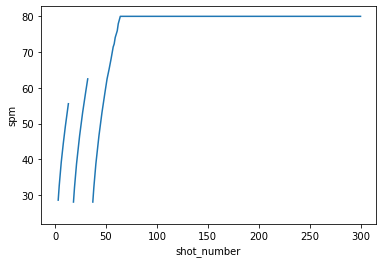

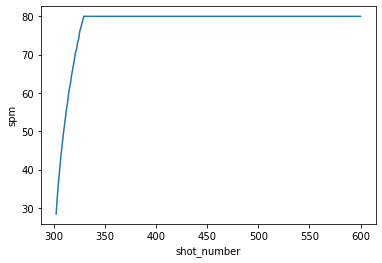

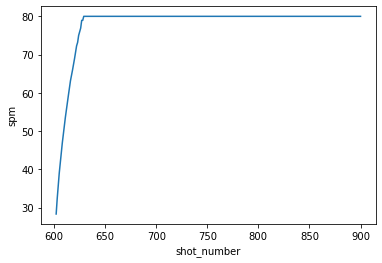

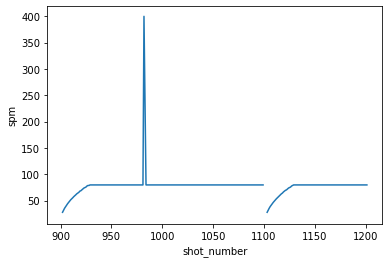

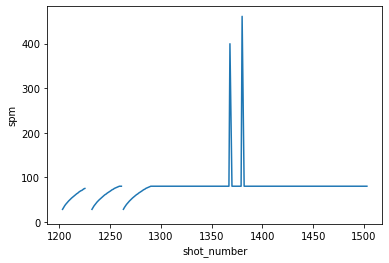

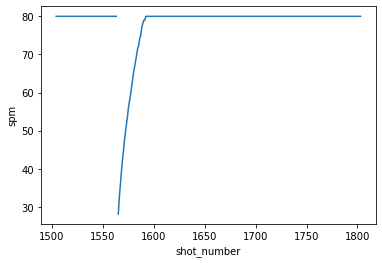

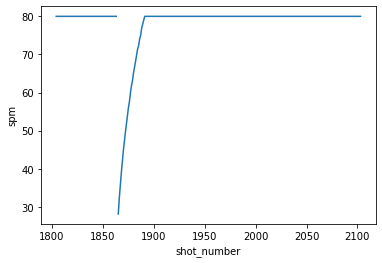

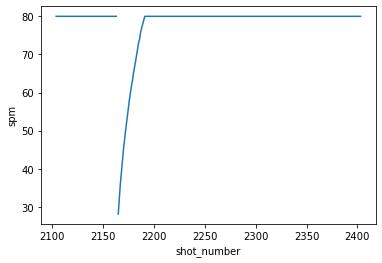

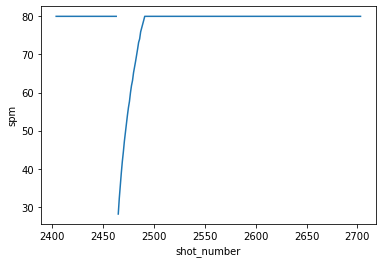

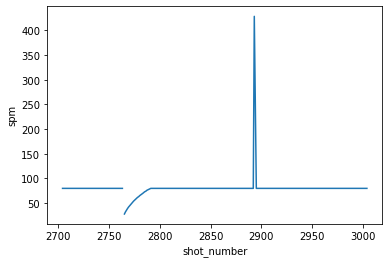

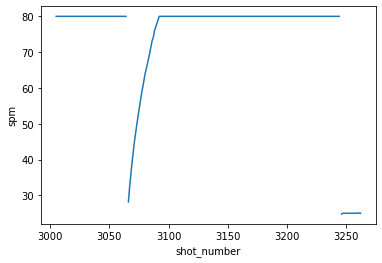

In [11]:
# ショット毎のSPM推移
import matplotlib.pyplot as plt

step = 300
for i in range(0, 3300, step):
    x = shots_meta_df.shot_number[i:i+step]
    y = shots_meta_df.spm[i:i+step]
    plt.xlabel("shot_number")
    plt.ylabel("spm")
    plt.plot(x, y)
    plt.show()

In [12]:
# spm
spm = float(shots_meta_df[shots_meta_df.shot_number == shot_number].spm)
print(f"spm：{spm}")

spm：60.60606060606061


## 特徴点抽出
1ショットから最大荷重点、荷重開始点、破断点を取得します。  

***shot_data***: 対象ショットデータ  
***spm***: spm  
***func***：適用するロジック  
***sub_func***：サブロジック  
***disp_chart***: グラフ表示

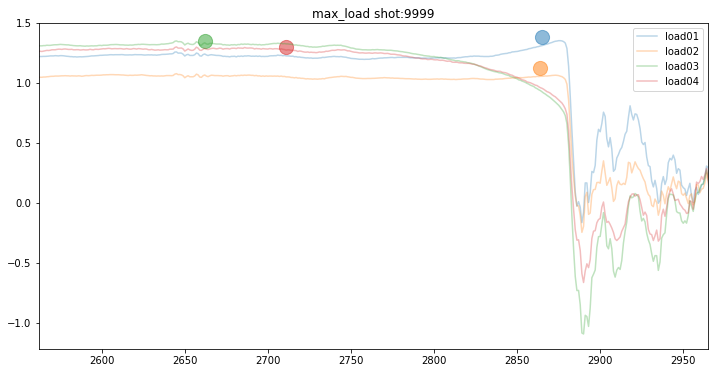

2021-05-13 16:00:40,024 [INFO] NumExpr defaulting to 8 threads.


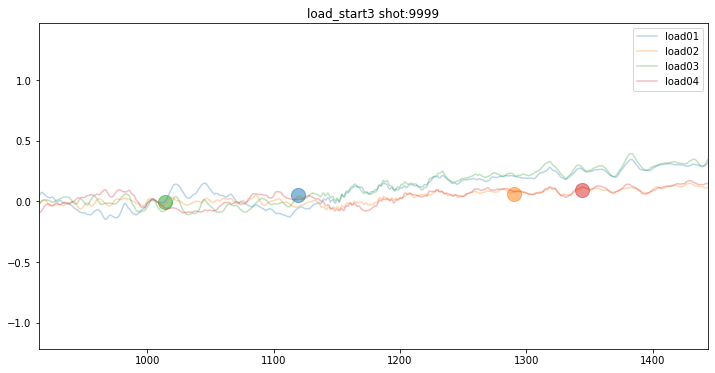

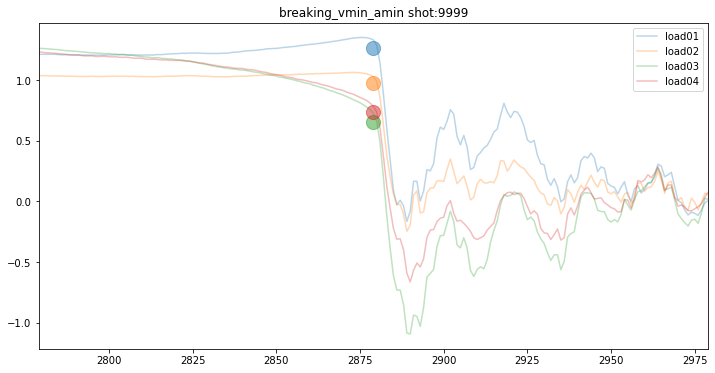

In [13]:
# 最初のショットの最大荷重点、荷重開始点、破断点を確認
max_load_indicies, max_load_values, max_debug_values = extract_features(shot_data=shot_df, spm=spm, func=max_load, disp_chart=True)
load_start_indicies, load_start_values, start_debug_values = extract_features(shot_data=shot_df, spm=spm, func=load_start3, disp_chart=True)
break_load_indicies, break_load_values, break_debug_values = extract_features(shot_data=shot_df, spm=spm, func=breaking_vmin_amin, sub_func=narrowing_v4min_mab, disp_chart=True)

In [14]:
# 各特徴点のインデックス番号と値を確認
print(f"【最大荷重点】\n indicies：{max_load_indicies}, values：{max_load_values}")
print(f"【荷重開始点】\n indicies：{load_start_indicies}, values：{load_start_values}")
print(f"【破断点】　　\n indicies：{break_load_indicies}, values：{break_load_values}")

【最大荷重点】
 indicies：[2865, 2864, 2662, 2711], values：[1.3787128446006778, 1.1258198485503463, 1.3463502786449402, 1.2963943036451098]
【荷重開始点】
 indicies：[1119, 1290, 1014, 1344], values：[0.05387969924812029, 0.06362656641604017, -0.002401002506265687, 0.09729323308270675]
【破断点】　　
 indicies：[2879, 2879, 2879, 2879], values：[1.265996061349155, 0.9724871649936309, 0.6566632503189952, 0.7354230047877176]


# 全ショットから特徴点抽出
全ショットから最大荷重点、荷重開始点、破断点を抽出し、Elasticsearchに保存します。  

***target***: 対象ショットデータ（yyyyMMddHHMMSS）  
***shots_df***: ショットデータのDataFrame
***shots_meta_df***: ショットメタデータのDataFrame
***feature***: 抽出する特徴点名（max/start/break）  
***func***：適用するロジック  
***sub_func***：サブロジック  
***exclude_shots***: 除外ショット(ex: exclude_shots=(1227, 1228, 1229))  

保存先インデックスは以下になります。  
* 最大荷重点：shots-yyyyMMddHHMMSS-max-point
* 荷重開始点：shots-yyyyMMddHHMMSS-start-point
* 破断点：shots-yyyyMMddHHMMSS-break-point

In [15]:
# 対象指定
shots_data_index = "shots-" + target + "-data"
shots_meta_index = "shots-" + target + "-meta"

In [16]:
%%time
dr = DataReader()
shots_df = dr.multi_process_read_all(shots_data_index)

2021-05-13 16:00:49,917 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-05-13 16:00:49,937 [INFO] Data read start. data_count: 13586763.


CPU times: user 1min 45s, sys: 9.07 s, total: 1min 54s
Wall time: 5min 48s


In [24]:
# 不正ショットの除外
exclude_shots = (983, 1227, 1228, 1229, 1369, 1381, 2894)

In [25]:
# 最大荷重点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="max",
    func=ef.max_load,
    sub_func=None,
    exclude_shots=exclude_shots,
)

2021-05-13 18:29:25,554 [INFO] apply start.
2021-05-13 18:29:25,764 [INFO] delete index 'shots-20210327141514-max-point' finished. result: {'acknowledged': True}
2021-05-13 18:29:26,844 [INFO] shot_number: 1227 was excluded.
2021-05-13 18:29:27,154 [INFO] shot_number: 1228 was excluded.
2021-05-13 18:29:27,405 [INFO] shot_number: 1229 was excluded.
2021-05-13 18:29:29,561 [INFO] shot_number: 2894 was excluded.
2021-05-13 18:29:34,023 [INFO] shot_number: 983 was excluded.
2021-05-13 18:29:35,675 [INFO] shot_number: 1369 was excluded.
2021-05-13 18:29:36,537 [INFO] shot_number: 1381 was excluded.
2021-05-13 18:29:48,690 [INFO] apply finished.


In [19]:
dr = DataReader()
max_index = "shots-" + target + "-max-point"
max_df = dr.read_all(max_index)
max_df

2021-05-13 17:21:46,730 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-05-13 17:21:46,859 [INFO] データ件数: 13028
2021-05-13 17:21:47,246 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value,displacement
0,1,load04,4943,4943,0.155258,44.78250
1,1,load01,5712,5712,0.283157,44.54625
2,1,load02,5950,5950,0.127714,44.51125
3,1,load03,6271,6271,0.339230,44.49375
4,2,load01,117929,8525,1.159921,40.45125
...,...,...,...,...,...,...
13023,3263,load01,13574938,5260,1.905189,39.89125
13024,3264,load03,13585120,4964,1.184361,40.44250
13025,3264,load04,13585179,5023,1.224875,40.36375
13026,3264,load01,13585724,5568,1.714814,39.54125


In [20]:
# 荷重開始点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="start",
    func=ef.load_start3,
    sub_func=None,
    exclude_shots=exclude_shots,
)

2021-05-13 17:21:51,849 [INFO] apply start.
2021-05-13 17:21:52,016 [INFO] delete index 'shots-20210327141514-start-point' finished. result: {'acknowledged': True}
2021-05-13 17:21:53,230 [INFO] shot_number: 1227 was excluded.
2021-05-13 17:21:53,476 [INFO] shot_number: 1228 was excluded.
2021-05-13 17:21:53,478 [INFO] shot_number: 1229 was excluded.
2021-05-13 17:21:56,797 [INFO] shot_number: 2894 was not found.
2021-05-13 17:22:03,762 [INFO] shot_number: 1369 was excluded.
2021-05-13 17:22:04,610 [INFO] shot_number: 1381 was excluded.
2021-05-13 17:22:04,669 [INFO] shot_number: 983 was excluded.
2021-05-13 17:22:25,340 [INFO] apply finished.


In [21]:
dr = DataReader()
start_index = "shots-" + target + "-start-point"
start_df = dr.read_all(start_index)
start_df

2021-05-13 17:22:51,225 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-05-13 17:22:51,252 [INFO] データ件数: 13028
2021-05-13 17:22:51,466 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value,displacement
0,1,load03,2455,2455,-0.011168,45.96375
1,1,load01,2494,2494,0.001193,45.94625
2,1,load02,2631,2631,-0.001962,45.88500
3,1,load04,2644,2644,-0.004366,45.87625
4,2,load04,113772,4368,0.004363,44.90500
...,...,...,...,...,...,...
13023,3263,load02,13571135,1457,-0.009293,46.21750
13024,3264,load01,13581565,1409,-0.018143,46.31375
13025,3264,load03,13581596,1440,-0.044704,46.27000
13026,3264,load04,13581641,1485,-0.027687,46.18250


In [22]:
# 破断点
apply(
    target=target,
    shots_df=shots_df,
    shots_meta_df=shots_meta_df,
    feature="break",
    func=ef.breaking_vmin_amin,
    sub_func=ef.narrowing_v4min_mab,
    exclude_shots=exclude_shots,
)

2021-05-13 17:22:55,452 [INFO] apply start.
2021-05-13 17:22:55,618 [INFO] delete index 'shots-20210327141514-break-point' finished. result: {'acknowledged': True}
2021-05-13 17:22:56,754 [INFO] shot_number: 1227 was excluded.
2021-05-13 17:22:57,055 [INFO] shot_number: 1228 was excluded.
2021-05-13 17:22:57,058 [INFO] shot_number: 1229 was excluded.
2021-05-13 17:23:00,028 [INFO] shot_number: 2894 was not found.
2021-05-13 17:23:05,706 [INFO] shot_number: 1369 was excluded.
2021-05-13 17:23:06,396 [INFO] shot_number: 1381 was excluded.
2021-05-13 17:23:07,541 [INFO] shot_number: 983 was excluded.
2021-05-13 17:23:23,384 [INFO] apply finished.


In [23]:
dr = DataReader()
break_index = "shots-" + target + "-break-point"
break_df = dr.read_all(break_index)
break_df

2021-05-13 17:24:04,568 [INFO] データを全件取得します。データ件数が多い場合、長時間かかる場合があります。
2021-05-13 17:24:04,580 [INFO] データ件数: 13028
2021-05-13 17:24:04,795 [INFO] Data reading has finished.


,shot_number,load,sequential_number,sequential_number_by_shot,value,displacement,break_channels
0,1,load01,6266,6266,0.276385,44.48500,"[load01, load02]"
1,1,load02,6266,6266,0.128082,44.48500,"[load01, load02]"
2,1,load03,6266,6266,0.348574,44.48500,"[load01, load02]"
3,1,load04,6266,6266,0.162974,44.48500,"[load01, load02]"
4,2,load04,119010,9606,1.230244,39.17375,"[load01, load02]"
...,...,...,...,...,...,...,...
13023,3263,load04,13575032,5354,-0.028044,39.71625,"[load03, load04]"
13024,3264,load02,13585772,5616,1.317613,39.48875,"[load03, load04]"
13025,3264,load01,13585773,5617,1.460389,39.48875,"[load03, load04]"
13026,3264,load03,13585780,5624,-0.430173,39.48875,"[load03, load04]"


In [27]:
# csv出力
max_df.to_csv("/datadrive/max_point.csv", index=False)
start_df.to_csv("/datadrive/start_point.csv", index=False)
break_df.to_csv("/datadrive/break_point.csv", index=False)